# Model 9: Swin Transformer V2 for Depth Regression (Transfer Learning)

---

**Architecture**
- Swin Transformer V2 Tiny pretrained backbone (from classification model)
- Transfer learning from pose classification task
- Single regression head for depth estimation
- Two-phase training: frozen backbone → full fine-tuning

**Hardware:** Apple M4 + 24GB Unified Memory (MPS)

**Note:** Memory-intensive transformer model - uses smaller batch size (8) and lower learning rate (5e-6)


## 1. Setup & Data Loading

In [1]:
# Standard libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR

# Transfer learning library
import timm

# Visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import cv2

# Torchvision for resizing
import torchvision.transforms as T

# Project modules
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# Import dataset
from src.data.depth_dataset import RegressDataset

# Import regression utilities
from src.utils.regression_utils import (
    train_epoch_regression,
    validate_epoch_regression,
    collect_predictions_regression,
    compute_regression_metrics,
    RegressionMetricsTracker,
    plot_regression_training_curves,
    plot_predictions_vs_actual,
    plot_residuals,
    plot_error_distribution,
    plot_depth_predictions_gallery,
    load_classification_backbone,
    freeze_backbone,
    unfreeze_backbone
)

# Set device
# Determine the device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

if device.type == 'mps':
    print("WARNING: Swin Transformer V2 is memory-intensive on MPS")
    print("   Using smaller batch size (8) to prevent memory issues")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries and utilities imported successfully")

Using device: mps
   Using smaller batch size (8) to prevent memory issues
All libraries and utilities imported successfully


In [46]:
# Model prefix for saving files
MODEL_PREFIX = '9_swin_v2_depth'
print(f"Model prefix: {MODEL_PREFIX}")

Model prefix: 9_swin_v2_depth


### Load Dataset & Create Splits

For regression, we use a simple random split (60/20/20) without stratification.

In [47]:
# Load full dataset
data_root = project_root / 'data'
full_dataset = RegressDataset(rootpath=str(data_root), augment=False)

print(f"Total samples: {len(full_dataset)}")

# Check a sample
sample_img, sample_depth = full_dataset[0]
print(f"\nSample image shape: {sample_img.shape}")
print(f"Sample depth value: {sample_depth.item():.4f}")

Total samples: 2000

Sample image shape: torch.Size([3, 224, 224])
Sample depth value: 0.7850


In [48]:
# Create random splits (60/20/20)
from sklearn.model_selection import train_test_split

# Get all indices
all_indices = list(range(len(full_dataset)))

# First split: 80% train+val, 20% test
train_val_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=42
)

# Second split: 75% of train+val becomes train (60% of total), 25% becomes val (20% of total)
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.25,  # 0.25 of 0.8 = 0.2 of total
    random_state=42
)

print(f"Split sizes:")
print(f"   Train: {len(train_idx)} ({len(train_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Val:   {len(val_idx)} ({len(val_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Test:  {len(test_idx)} ({len(test_idx)/len(full_dataset)*100:.1f}%)")

Split sizes:
   Train: 1200 (60.0%)
   Val:   400 (20.0%)
   Test:  400 (20.0%)


In [49]:
# Verify depth distribution across splits
train_depths = [full_dataset[i][1].item() for i in train_idx]
val_depths = [full_dataset[i][1].item() for i in val_idx]
test_depths = [full_dataset[i][1].item() for i in test_idx]

print("\nDepth Statistics:")
print(f"Train - Min: {min(train_depths):.3f}, Max: {max(train_depths):.3f}, Mean: {np.mean(train_depths):.3f}")
print(f"Val   - Min: {min(val_depths):.3f}, Max: {max(val_depths):.3f}, Mean: {np.mean(val_depths):.3f}")
print(f"Test  - Min: {min(test_depths):.3f}, Max: {max(test_depths):.3f}, Mean: {np.mean(test_depths):.3f}")


Depth Statistics:
Train - Min: 0.000, Max: 1.000, Mean: 0.441
Val   - Min: 0.000, Max: 0.998, Mean: 0.435
Test  - Min: 0.000, Max: 1.000, Mean: 0.457


In [50]:
# Create dataset splits with augmentation for training
train_dataset = RegressDataset(rootpath=str(data_root), augment=True, random_ratio=0.5)
val_dataset = RegressDataset(rootpath=str(data_root), augment=False)
test_dataset = RegressDataset(rootpath=str(data_root), augment=False)

# Create subsets
train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(val_dataset, val_idx)
test_subset = Subset(test_dataset, test_idx)

# Create dataloaders (SMALLER batch size for Swin Transformer V2)
batch_size = 8  # Reduced for memory constraints

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print("Datasets and loaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

Datasets and loaders created
   Train batches: 150
   Val batches: 50
   Test batches: 50


In [51]:
# IMPORTANT: Swin-V2 requires 256x256 images, but dataset provides 224x224
# We need to add a resize transform to the dataloaders

class ResizingDataLoader:
    """Wrapper that resizes images from 224x224 to 256x256"""
    def __init__(self, dataloader, target_size=256):
        self.dataloader = dataloader
        self.resize = T.Resize((target_size, target_size))
    
    def __iter__(self):
        for images, depths in self.dataloader:
            # Resize images from 224x224 to 256x256
            images = self.resize(images)
            yield images, depths
    
    def __len__(self):
        return len(self.dataloader)

# Wrap all dataloaders
train_loader = ResizingDataLoader(train_loader, target_size=256)
val_loader = ResizingDataLoader(val_loader, target_size=256)
test_loader = ResizingDataLoader(test_loader, target_size=256)

print("Dataloaders wrapped to resize 224x224 -> 256x256 for Swin-V2")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")
print("\nWARNING: Memory usage will be higher due to 256x256 images!")

Dataloaders wrapped to resize 224x224 -> 256x256 for Swin-V2
   Train batches: 150
   Val batches: 50
   Test batches: 50



## 2. Model Architecture

**Swin Transformer V2 for Regression:**
- Uses pretrained Swin-V2 Tiny as feature extractor
- Model: `swinv2_tiny_window16_256.ms_in1k` (requires 256x256 input)
- Feature dimension: 768
- Single regression head outputting continuous depth value
- Transfer learning from classification model trained on pose estimation

**Key Differences from CNN:**
- Self-attention mechanism instead of convolution
- Shifted window attention for efficiency
- Hierarchical feature maps like CNNs
- More parameters but better global context modeling

In [52]:
class SwinV2Regression(nn.Module):
    """
    Swin Transformer V2 for depth regression
    
    Uses pretrained Swin-V2 Tiny backbone with a single regression head
    for continuous depth value prediction.
    
    Args:
        pretrained: Use pretrained weights from timm
        dropout_rate: Dropout probability in regression head
        img_size: Input image size (must be 256 for this model)
    """
    
    def __init__(
        self,
        pretrained=True,
        dropout_rate=0.3,
        img_size=256
    ):
        super(SwinV2Regression, self).__init__()
        
        # Load pretrained Swin-V2 Tiny (feature dimension = 768)
        # swinv2_tiny_window16_256 works natively with 256x256 images
        self.backbone = timm.create_model(
            'swinv2_tiny_window16_256.ms_in1k',
            pretrained=pretrained,
            num_classes=0,  # Remove classification head
            img_size=img_size
        )
        
        # Feature dimension from Swin-V2 Tiny
        self.feature_dim = self.backbone.num_features  # 768
        
        # Regression head
        self.regression_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 1)
        )
        
        # Initialize regression head
        self._initialize_head()
    
    def _initialize_head(self):
        """Initialize weights for regression head"""
        for m in self.regression_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x, return_features=False):
        """
        Forward pass
        
        Args:
            x: Input tensor of shape (batch_size, 3, 256, 256)
            return_features: If True, return features along with predictions
        
        Returns:
            depth_out: Depth predictions (batch_size, 1)
            features: (optional) Feature embeddings (batch_size, feature_dim)
        """
        # Extract features using backbone
        features = self.backbone(x)
        
        # Regression output
        depth_out = self.regression_head(features)
        
        if return_features:
            return depth_out, features
        return depth_out
    
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_attention_weights(self, x, layer_idx=-1):
        """Extract attention weights from specified transformer layer"""
        # This would require modifying the forward pass to capture attention
        # For now, just extract features
        self.eval()
        with torch.no_grad():
            features = self.backbone(x)
        return features

In [53]:
# Test model
test_model = SwinV2Regression(pretrained=False)
test_input = torch.randn(1, 3, 256, 256)  # 256x256 for Swin-V2
depth_out = test_model(test_input)

print(f"Model architecture defined")
print(f"   Input shape: {test_input.shape}")
print(f"   Depth output shape: {depth_out.shape}")
print(f"   Feature dim: {test_model.feature_dim}")
print(f"   Total parameters: {test_model.get_num_params():,}")

del test_model, test_input, depth_out

Model architecture defined
   Input shape: torch.Size([1, 3, 256, 256])
   Depth output shape: torch.Size([1, 1])
   Feature dim: 768
   Total parameters: 27,580,459


## 3. Transfer Learning Setup

Load pretrained backbone from the classification model and initialize the regression model.

In [ ]:
# Path to classification model checkpoint
classification_model_path = project_root / 'models' / '4_swin_v2.pth'

# Check if classification model exists
if not classification_model_path.exists():
    print(f"WARNING: Classification model not found at {classification_model_path}")
    print("Will use ImageNet pretrained weights instead")
    use_classification_weights = False
else:
    print(f"Classification model found at {classification_model_path}")
    use_classification_weights = True

Classification model found at /Users/adgodoyo/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/Textos y Trabajos/Academic Imperial/Deep Learning/Final Assignment/mycode/models/swin_v2_baseline_best.pth


In [55]:
# Initialize regression model
model = SwinV2Regression(
    pretrained=True,  # Start with ImageNet weights
    dropout_rate=0.3,
    img_size=256
).to(device)

print(f"Regression model initialized")
print(f"   Total parameters: {model.get_num_params():,}")

# Load classification backbone if available
if use_classification_weights:
    print(f"\nLoading classification backbone weights...")
    model = load_classification_backbone(
        classification_model_path=str(classification_model_path),
        regression_model=model,
        device=device,
        strict=False
    )
    print("Classification backbone loaded successfully")
else:
    print("\nUsing ImageNet pretrained weights only")

Regression model initialized
   Total parameters: 27,580,459

Loading classification backbone weights...
Loaded 219/223 layers from classification model
Classification backbone loaded successfully


## 4. Phase 1: Frozen Backbone Training

First, we train only the regression head while keeping the backbone frozen. This allows the new regression head to adapt to the depth estimation task without disrupting the pretrained features.

In [56]:
# Freeze backbone for phase 1
print("Phase 1: Freezing backbone, training regression head only\n")
model = freeze_backbone(model)

# Loss function
criterion = nn.MSELoss()

# Optimizer (only for regression head)
optimizer_phase1 = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=0.05  # Higher weight decay for transformers
)

# Learning rate scheduler
scheduler_phase1 = CosineAnnealingLR(
    optimizer_phase1,
    T_max=30,
    eta_min=1e-6
)

# Metrics tracker
tracker_phase1 = RegressionMetricsTracker()

print(f"Optimizer: AdamW (lr=1e-3, weight_decay=0.05)")
print(f"Scheduler: CosineAnnealingLR (T_max=30)")
print(f"Criterion: MSELoss")

Phase 1: Freezing backbone, training regression head only

Frozen parameters: 10,303,722
Trainable parameters: 17,276,737
Optimizer: AdamW (lr=1e-3, weight_decay=0.05)
Scheduler: CosineAnnealingLR (T_max=30)
Criterion: MSELoss


In [18]:
# Training configuration for phase 1
num_epochs_phase1 = 20
best_val_loss_phase1 = float('inf')

print(f"Starting Phase 1 training for {num_epochs_phase1} epochs...")
print(f"Training only regression head (backbone frozen)\n")

for epoch in range(num_epochs_phase1):
    # Train
    train_metrics = train_epoch_regression(
        model=model,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer_phase1,
        device=device
    )
    
    # Validate
    val_metrics = validate_epoch_regression(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=device
    )
    
    # Update learning rate
    scheduler_phase1.step()
    current_lr = optimizer_phase1.param_groups[0]['lr']
    
    # Update tracker
    tracker_phase1.update({
        'train_loss': train_metrics['loss'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_loss': val_metrics['loss'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'lr': current_lr
    })
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_phase1}]")
        print(f"  Train - Loss: {train_metrics['loss']:.4f}, RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f}, RMSE: {val_metrics['rmse']:.4f}, MAE: {val_metrics['mae']:.4f}")
        print(f"  LR: {current_lr:.6f}")
    
    # Save best model
    if val_metrics['loss'] < best_val_loss_phase1:
        best_val_loss_phase1 = val_metrics['loss']
        best_model_state_phase1 = model.state_dict()
        print(f"  -> New best validation loss: {best_val_loss_phase1:.4f}")

print(f"\nPhase 1 training completed!")
print(f"Best validation loss: {best_val_loss_phase1:.4f}")

# Load best model from phase 1
model.load_state_dict(best_model_state_phase1)

Starting Phase 1 training for 20 epochs...
Training only regression head (backbone frozen)

Epoch [1/20]
  Train - Loss: 0.0017, RMSE: 0.0418, MAE: 0.0319
  Val   - Loss: 0.0018, RMSE: 0.0426, MAE: 0.0306
  LR: 0.000004
  -> New best validation loss: 0.0018
  -> New best validation loss: 0.0018
Epoch [5/20]
  Train - Loss: 0.0019, RMSE: 0.0431, MAE: 0.0329
  Val   - Loss: 0.0017, RMSE: 0.0418, MAE: 0.0307
  LR: 0.000068
  -> New best validation loss: 0.0017
Epoch [10/20]
  Train - Loss: 0.0036, RMSE: 0.0596, MAE: 0.0465
  Val   - Loss: 0.0025, RMSE: 0.0503, MAE: 0.0378
  LR: 0.000251
Epoch [15/20]
  Train - Loss: 0.0062, RMSE: 0.0787, MAE: 0.0621
  Val   - Loss: 0.0113, RMSE: 0.1062, MAE: 0.0921
  LR: 0.000501
Epoch [20/20]
  Train - Loss: 0.0119, RMSE: 0.1092, MAE: 0.0850
  Val   - Loss: 0.0050, RMSE: 0.0710, MAE: 0.0570
  LR: 0.000750

Phase 1 training completed!
Best validation loss: 0.0017


<All keys matched successfully>

In [23]:
# Save phase 1 model
models_dir = project_root / 'models'
models_dir.mkdir(exist_ok=True)

phase1_model_path = models_dir / '9_swin_v2_depth_phase1.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer_phase1.state_dict(),
    'best_val_loss': best_val_loss_phase1,
    'tracker_history': tracker_phase1.get_history()
}, phase1_model_path)

print(f"Phase 1 model saved to: {phase1_model_path}")

Phase 1 model saved to: /Users/adgodoyo/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/Textos y Trabajos/Academic Imperial/Deep Learning/Final Assignment/mycode/models/9_swin_v2_depth_phase1.pth


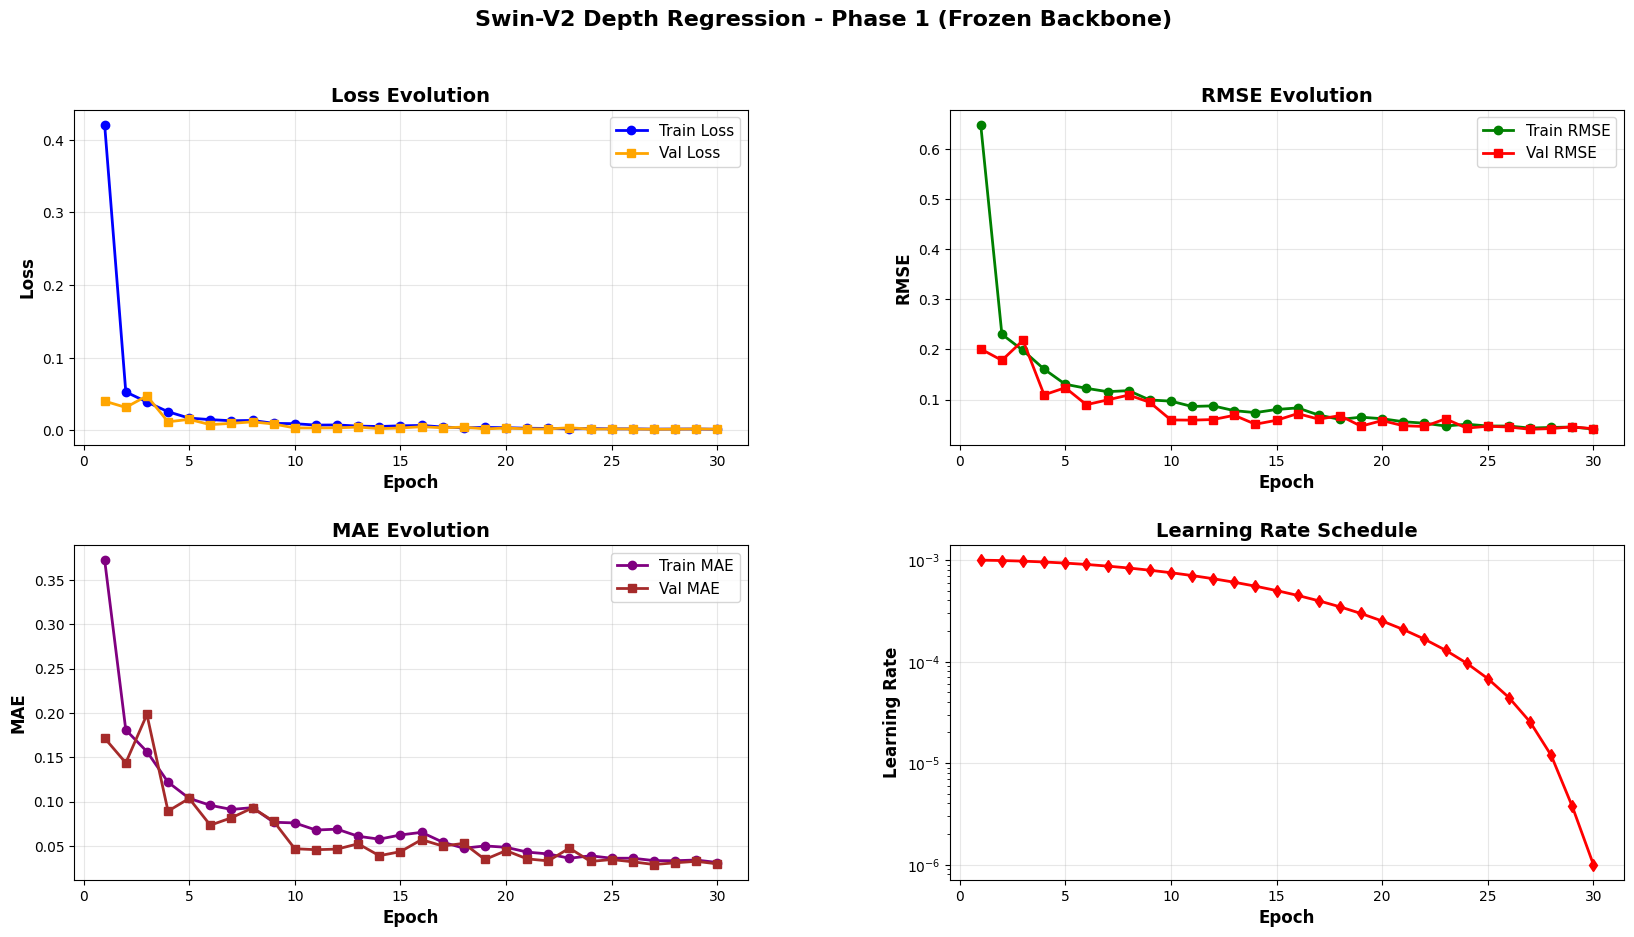

In [ ]:
# Plot phase 1 training curves
reports_dir = project_root / 'reports'
reports_dir.mkdir(exist_ok=True)

plot_regression_training_curves(
    tracker_history=tracker_phase1.get_history(),
    save_path=reports_dir / '9_swin_v2_depth_phase1_training_curves2.png',
    title='Swin-V2 Depth Regression - Phase 1 (Frozen Backbone)'
)

## 5. Phase 2: Full Fine-tuning (Unfrozen Backbone)

Now we unfreeze all layers and fine-tune the entire model with a much lower learning rate (5e-6 for transformers). This allows the backbone to adapt specifically to the depth estimation task.

In [ ]:
# Unfreeze all layers for full fine-tuning
print("Phase 2: Unfreezing all layers for full fine-tuning\n")
model = unfreeze_backbone(model)

# Phase 2 configuration - lower learning rate and higher weight decay for transformers
num_epochs_phase2 = 80
lr_phase2 = 5e-6  # Even lower for transformers
weight_decay_phase2 = 0.05  # Higher weight decay for transformers
patience_phase2 = 15

# Optimizer for phase 2
optimizer_phase2 = torch.optim.AdamW(
    model.parameters(),
    lr=lr_phase2,
    weight_decay=weight_decay_phase2
)

# Scheduler for phase 2
scheduler_phase2 = CosineAnnealingLR(
    optimizer_phase2,
    T_max=num_epochs_phase2,
    eta_min=1e-7
)

# Metrics tracker for phase 2
tracker_phase2 = RegressionMetricsTracker()

print(f"Optimizer: AdamW (lr={lr_phase2}, weight_decay={weight_decay_phase2})")
print(f"Scheduler: CosineAnnealingLR (T_max={num_epochs_phase2})")
print(f"Early stopping patience: {patience_phase2}")
print(f"Criterion: MSELoss")

Phase 2: Unfreezing all layers for full fine-tuning

Trainable parameters: 27,580,459/27,580,459
Optimizer: AdamW (lr=5e-06, weight_decay=0.05)
Scheduler: CosineAnnealingLR (T_max=30)
Early stopping patience: 15
Criterion: MSELoss


In [23]:
# Training loop for phase 2
best_val_loss_phase2 = float('inf')
patience_counter = 0

print(f"Starting Phase 2 training for {num_epochs_phase2} epochs...")
print(f"Training full model (all layers unfrozen)\n")

for epoch in range(num_epochs_phase2):
    # Train
    train_metrics = train_epoch_regression(
        model=model,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer_phase2,
        device=device
    )
    
    # Validate
    val_metrics = validate_epoch_regression(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=device
    )
    
    # Update learning rate
    scheduler_phase2.step()
    current_lr = optimizer_phase2.param_groups[0]['lr']
    
    # Update tracker
    tracker_phase2.update({
        'train_loss': train_metrics['loss'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_loss': val_metrics['loss'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'lr': current_lr
    })
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_phase2}]")
        print(f"  Train - Loss: {train_metrics['loss']:.4f}, RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f}, RMSE: {val_metrics['rmse']:.4f}, MAE: {val_metrics['mae']:.4f}")
        print(f"  LR: {current_lr:.6f}")
    
    # Save best model
    if val_metrics['loss'] < best_val_loss_phase2:
        best_val_loss_phase2 = val_metrics['loss']
        best_model_state_phase2 = model.state_dict()
        patience_counter = 0
        print(f"  -> New best validation loss: {best_val_loss_phase2:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience_phase2:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"No improvement for {patience_phase2} epochs")
            break

print(f"\nPhase 2 training completed!")
print(f"Best validation loss: {best_val_loss_phase2:.4f}")

# Load best model from phase 2
model.load_state_dict(best_model_state_phase2)

Starting Phase 2 training for 30 epochs...
Training full model (all layers unfrozen)

Epoch [1/30]
  Train - Loss: 0.0321, RMSE: 0.1793, MAE: 0.1391
  Val   - Loss: 0.0071, RMSE: 0.0844, MAE: 0.0660
  LR: 0.000005
  -> New best validation loss: 0.0071
  -> New best validation loss: 0.0056
Epoch [5/30]
  Train - Loss: 0.0224, RMSE: 0.1497, MAE: 0.1147
  Val   - Loss: 0.0051, RMSE: 0.0715, MAE: 0.0544
  LR: 0.000005
  -> New best validation loss: 0.0051
  -> New best validation loss: 0.0044
  -> New best validation loss: 0.0043
  -> New best validation loss: 0.0039
Epoch [10/30]
  Train - Loss: 0.0168, RMSE: 0.1298, MAE: 0.0976
  Val   - Loss: 0.0038, RMSE: 0.0616, MAE: 0.0464
  LR: 0.000004
  -> New best validation loss: 0.0038
  -> New best validation loss: 0.0035
  -> New best validation loss: 0.0034
Epoch [15/30]
  Train - Loss: 0.0143, RMSE: 0.1195, MAE: 0.0889
  Val   - Loss: 0.0034, RMSE: 0.0585, MAE: 0.0439
  LR: 0.000003
  -> New best validation loss: 0.0034
  -> New best valida

<All keys matched successfully>

In [ ]:
# Save phase 2 model
phase2_model_path = project_root /'models' / '10_swin_v2_depth_phase2.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer_phase2.state_dict(),
    'best_val_loss': best_val_loss_phase2,
    'tracker_history': tracker_phase2.get_history()
}, phase2_model_path)

print(f"Phase 2 model saved to: {phase2_model_path}")

Phase 2 model saved to: /Users/adgodoyo/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/Textos y Trabajos/Academic Imperial/Deep Learning/Final Assignment/mycode/models/9_swin_v2_depth_phase2.pth


### Performance Comparison: Phase 1 vs Phase 2

Compare the performance of both training phases to understand the impact of full fine-tuning.

In [63]:
model_path = project_root / "models" / "9_swin_v2_depth_phase1.pth"

model_phase1 = SwinV2Regression(
    pretrained=False,
    dropout_rate=0.3,
    img_size=256
).to(device)

checkpoint = torch.load(
    model_path,
    map_location=device,
    weights_only=False   # REQUIRED in PyTorch 2.6+
)

model_phase1.load_state_dict(checkpoint["model_state_dict"])
model_phase1.eval()

SwinV2Regression(
  (backbone): SwinTransformerV2(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerV2Stage(
        (downsample): Identity()
        (blocks): ModuleList(
          (0): SwinTransformerV2Block(
            (attn): WindowAttention(
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=3, bias=False)
              )
              (qkv): Linear(in_features=96, out_features=288, bias=False)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (norm1): LayerNo

In [64]:
# Get phase 1 predictions
phase1_results = collect_predictions_regression(
    model=model_phase1,
    dataloader=test_loader,
    device=device,
    return_images=False
)
phase1_metrics = compute_regression_metrics(
    predictions=phase1_results['predictions'],
    targets=phase1_results['targets']
)

print("\nTesting Phase 2 model...")
# Load phase 2 model
model_phase2 = SwinV2Regression(pretrained=False, dropout_rate=0.3, img_size=256).to(device)
model_phase2.load_state_dict(best_model_state_phase2)

# Get phase 2 predictions
phase2_results = collect_predictions_regression(
    model=model_phase2,
    dataloader=test_loader,
    device=device,
    return_images=False
)
phase2_metrics = compute_regression_metrics(
    predictions=phase2_results['predictions'],
    targets=phase2_results['targets']
)

print("\nPhase 1 Test Metrics:")
print(f"  RMSE: {phase1_metrics['rmse']:.6f}")
print(f"  MAE:  {phase1_metrics['mae']:.6f}")
print(f"  R2:   {phase1_metrics['r2']:.6f}")

print("\nPhase 2 Test Metrics:")
print(f"  RMSE: {phase2_metrics['rmse']:.6f}")
print(f"  MAE:  {phase2_metrics['mae']:.6f}")
print(f"  R2:   {phase2_metrics['r2']:.6f}")


Testing Phase 2 model...

Phase 1 Test Metrics:
  RMSE: 0.077166
  MAE:  0.060904
  R2:   0.940563

Phase 2 Test Metrics:
  RMSE: 0.050394
  MAE:  0.038982
  R2:   0.974651


NameError: name 'best_val_loss_phase1' is not defined

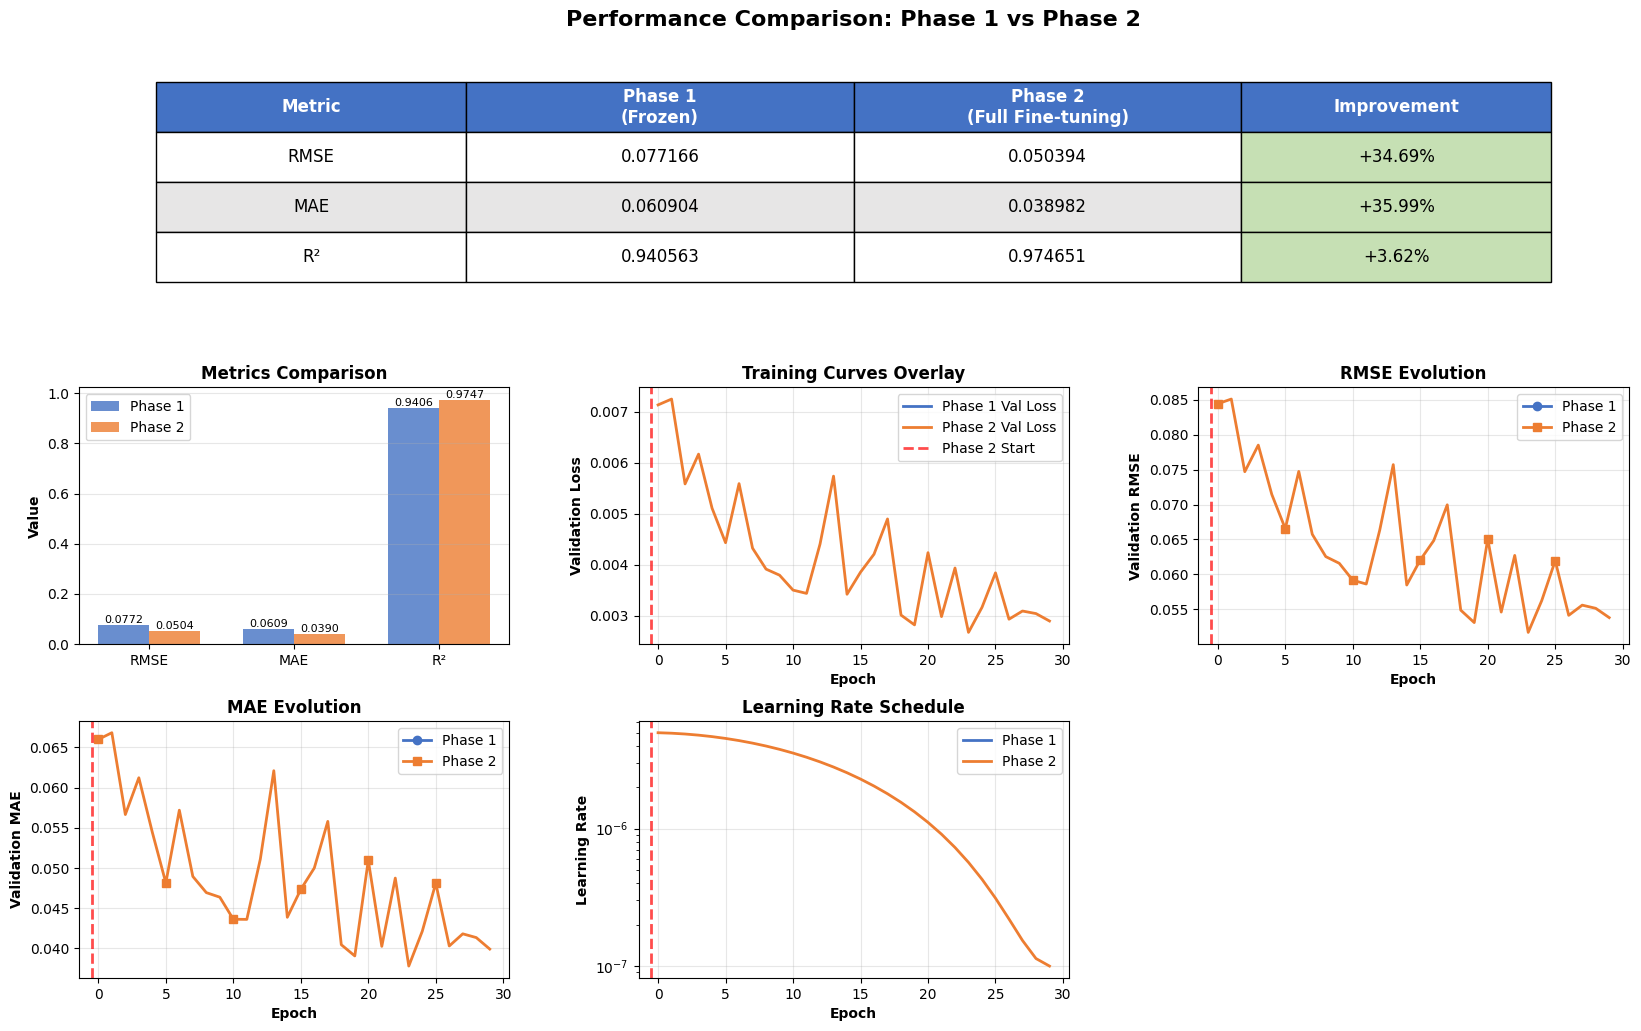

In [65]:
# Create comprehensive comparison visualization
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Comparison Table (top left)
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')

# Calculate improvements
rmse_improvement = ((phase1_metrics['rmse'] - phase2_metrics['rmse']) / phase1_metrics['rmse']) * 100
mae_improvement = ((phase1_metrics['mae'] - phase2_metrics['mae']) / phase1_metrics['mae']) * 100
r2_improvement = ((phase2_metrics['r2'] - phase1_metrics['r2']) / phase1_metrics['r2']) * 100

comparison_data = [
    ['Metric', 'Phase 1\n(Frozen)', 'Phase 2\n(Full Fine-tuning)', 'Improvement'],
    ['RMSE', f"{phase1_metrics['rmse']:.6f}", f"{phase2_metrics['rmse']:.6f}", 
     f"{rmse_improvement:+.2f}%" if rmse_improvement > 0 else f"{rmse_improvement:.2f}%"],
    ['MAE', f"{phase1_metrics['mae']:.6f}", f"{phase2_metrics['mae']:.6f}", 
     f"{mae_improvement:+.2f}%" if mae_improvement > 0 else f"{mae_improvement:.2f}%"],
    ['R²', f"{phase1_metrics['r2']:.6f}", f"{phase2_metrics['r2']:.6f}", 
     f"{r2_improvement:+.2f}%" if r2_improvement > 0 else f"{r2_improvement:.2f}%"],
]

table = ax1.table(comparison_data, cellLoc='center', loc='center',
                  colWidths=[0.2, 0.25, 0.25, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 3)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style data rows
for i in range(1, 4):
    for j in range(4):
        if j == 3:  # Improvement column
            improvement_val = float(comparison_data[i][3].rstrip('%'))
            if improvement_val > 0:
                table[(i, j)].set_facecolor('#C6E0B4')  # Green for positive
            else:
                table[(i, j)].set_facecolor('#F4B084')  # Orange for negative
        else:
            table[(i, j)].set_facecolor('#E7E6E6' if i % 2 == 0 else 'white')

ax1.set_title('Performance Comparison: Phase 1 vs Phase 2', fontsize=16, fontweight='bold', pad=20)

# 2. Bar chart comparison (top right)
ax2 = fig.add_subplot(gs[1, 0])
metrics_names = ['RMSE', 'MAE', 'R²']
phase1_vals = [phase1_metrics['rmse'], phase1_metrics['mae'], phase1_metrics['r2']]
phase2_vals = [phase2_metrics['rmse'], phase2_metrics['mae'], phase2_metrics['r2']]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax2.bar(x - width/2, phase1_vals, width, label='Phase 1', alpha=0.8, color='#4472C4')
bars2 = ax2.bar(x + width/2, phase2_vals, width, label='Phase 2', alpha=0.8, color='#ED7D31')

ax2.set_ylabel('Value', fontweight='bold')
ax2.set_title('Metrics Comparison', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_names)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# 3. Training curves overlay (middle)
ax3 = fig.add_subplot(gs[1, 1])
phase1_epochs = range(len(tracker_phase1.get_history()['val_loss']))
phase2_start = len(tracker_phase1.get_history()['val_loss'])
phase2_epochs = range(phase2_start, phase2_start + len(tracker_phase2.get_history()['val_loss']))

ax3.plot(phase1_epochs, tracker_phase1.get_history()['val_loss'], 
         label='Phase 1 Val Loss', linewidth=2, color='#4472C4')
ax3.plot(phase2_epochs, tracker_phase2.get_history()['val_loss'], 
         label='Phase 2 Val Loss', linewidth=2, color='#ED7D31')
ax3.axvline(x=phase2_start-0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Phase 2 Start')
ax3.set_xlabel('Epoch', fontweight='bold')
ax3.set_ylabel('Validation Loss', fontweight='bold')
ax3.set_title('Training Curves Overlay', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. RMSE evolution (middle right)
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(phase1_epochs, tracker_phase1.get_history()['val_rmse'], 
         label='Phase 1', linewidth=2, color='#4472C4', marker='o', markevery=5)
ax4.plot(phase2_epochs, tracker_phase2.get_history()['val_rmse'], 
         label='Phase 2', linewidth=2, color='#ED7D31', marker='s', markevery=5)
ax4.axvline(x=phase2_start-0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax4.set_xlabel('Epoch', fontweight='bold')
ax4.set_ylabel('Validation RMSE', fontweight='bold')
ax4.set_title('RMSE Evolution', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. MAE evolution (bottom left)
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(phase1_epochs, tracker_phase1.get_history()['val_mae'], 
         label='Phase 1', linewidth=2, color='#4472C4', marker='o', markevery=5)
ax5.plot(phase2_epochs, tracker_phase2.get_history()['val_mae'], 
         label='Phase 2', linewidth=2, color='#ED7D31', marker='s', markevery=5)
ax5.axvline(x=phase2_start-0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax5.set_xlabel('Epoch', fontweight='bold')
ax5.set_ylabel('Validation MAE', fontweight='bold')
ax5.set_title('MAE Evolution', fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Learning rate schedule (bottom middle)
ax6 = fig.add_subplot(gs[2, 1])
phase1_lr = tracker_phase1.get_history()['lr']
phase2_lr = tracker_phase2.get_history()['lr']
ax6.plot(phase1_epochs, phase1_lr, label='Phase 1', linewidth=2, color='#4472C4')
ax6.plot(phase2_epochs, phase2_lr, label='Phase 2', linewidth=2, color='#ED7D31')
ax6.axvline(x=phase2_start-0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax6.set_xlabel('Epoch', fontweight='bold')
ax6.set_ylabel('Learning Rate', fontweight='bold')
ax6.set_title('Learning Rate Schedule', fontweight='bold')
ax6.set_yscale('log')
ax6.legend()
ax6.grid(alpha=0.3)

# 7. Summary text (bottom right)
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

summary_text = f"""
PHASE COMPARISON SUMMARY

Phase 1 (Frozen Backbone):
  • Best Val Loss: {best_val_loss_phase1:.6f}
  • Test RMSE: {phase1_metrics['rmse']:.6f}
  • Test R²: {phase1_metrics['r2']:.6f}
  • Epochs: {len(tracker_phase1.get_history()['val_loss'])}

Phase 2 (Full Fine-tuning):
  • Best Val Loss: {best_val_loss_phase2:.6f}
  • Test RMSE: {phase2_metrics['rmse']:.6f}
  • Test R²: {phase2_metrics['r2']:.6f}
  • Epochs: {len(tracker_phase2.get_history()['val_loss'])}

Overall Improvement:
  • RMSE: {rmse_improvement:+.2f}%
  • MAE: {mae_improvement:+.2f}%
  • R²: {r2_improvement:+.2f}%

Recommendation:
  {'Phase 2 shows better performance' if phase2_metrics['rmse'] < phase1_metrics['rmse'] else 'Phase 1 shows better performance'}
"""

ax7.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Swin-V2 Depth Regression: Two-Phase Training Analysis', 
             fontsize=18, fontweight='bold', y=0.98)
plt.savefig(reports_dir / '9_swin_v2_depth_phase_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison visualization saved")

### Model Selection

Select which model to use for final evaluation and visualizations. You can choose between Phase 1 (frozen backbone) or Phase 2 (full fine-tuning) based on the comparison above.

In [66]:
# Select which model to use for final evaluation
# Options: 'phase1' or 'phase2'
SELECTED_MODEL = 'phase2'  # Change this to 'phase1' if preferred

if SELECTED_MODEL == 'phase1':
    final_model = model_phase1
    final_model_name = 'Phase 1 (Frozen Backbone)'
    print("Using Phase 1 model (frozen backbone)")
    print(f"  Test RMSE: {phase1_metrics['rmse']:.6f}")
    print(f"  Test R²: {phase1_metrics['r2']:.6f}")
else:
    final_model = model_phase2
    final_model_name = 'Phase 2 (Full Fine-tuning)'
    print("Using Phase 2 model (full fine-tuning)")
    print(f"  Test RMSE: {phase2_metrics['rmse']:.6f}")
    print(f"  Test R²: {phase2_metrics['r2']:.6f}")

print(f"\nSelected model: {final_model_name}")

Using Phase 2 model (full fine-tuning)
  Test RMSE: 0.050394
  Test R²: 0.974651

Selected model: Phase 2 (Full Fine-tuning)


## 7. Evaluation & Analysis

Comprehensive evaluation of the selected model on the test set.

### 6.2 Test Set Evaluation

In [67]:
# Collect predictions on test set using selected model
test_results = collect_predictions_regression(
    model=final_model,
    dataloader=test_loader,
    device=device,
    return_images=True
)

print("Test set predictions collected")
print(f"   Predictions shape: {test_results['predictions'].shape}")
print(f"   Targets shape: {test_results['targets'].shape}")
print(f"   Images shape: {test_results['images'].shape}")

Test set predictions collected
   Predictions shape: (400,)
   Targets shape: (400,)
   Images shape: (400, 3, 256, 256)


In [68]:
# Compute comprehensive metrics on selected model
test_metrics = compute_regression_metrics(
    predictions=test_results['predictions'],
    targets=test_results['targets']
)

print(f"\n{final_model_name} - Test Set Performance:")
print("="*50)
print(f"MSE:           {test_metrics['mse']:.6f}")
print(f"RMSE:          {test_metrics['rmse']:.6f}")
print(f"MAE:           {test_metrics['mae']:.6f}")
print(f"Median AE:     {test_metrics['median_ae']:.6f}")
print(f"R2:            {test_metrics['r2']:.6f}")
print(f"Max Error:     {test_metrics['max_error']:.6f}")
print(f"Std Error:     {test_metrics['std_error']:.6f}")
if 'mape' in test_metrics:
    print(f"MAPE:          {test_metrics['mape']:.2f}%")
print("="*50)


Phase 2 (Full Fine-tuning) - Test Set Performance:
MSE:           0.002540
RMSE:          0.050394
MAE:           0.038982
Median AE:     0.031936
R2:            0.974651
Max Error:     0.214895
Std Error:     0.048736


### 8.2 Predictions vs Actual Scatter Plot

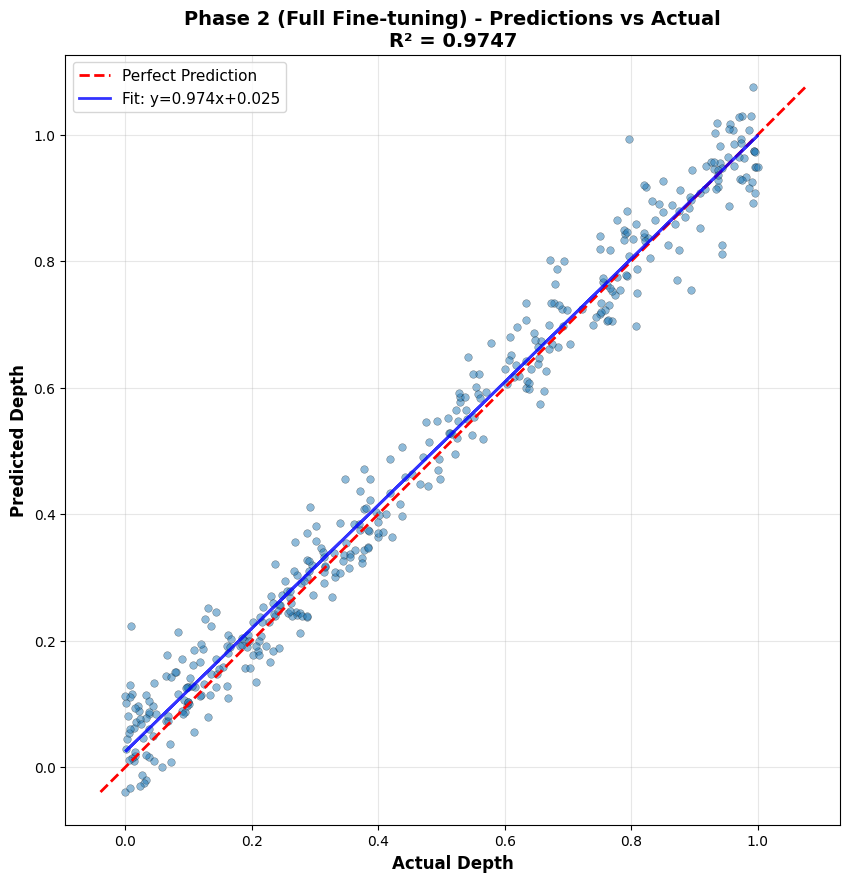

In [70]:
plot_predictions_vs_actual(
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    save_path= project_root / 'reports' / f'{MODEL_PREFIX}_final_predictions_vs_actual.png',
    title=f'{final_model_name} - Predictions vs Actual'
)

### 8.3 Residual Analysis

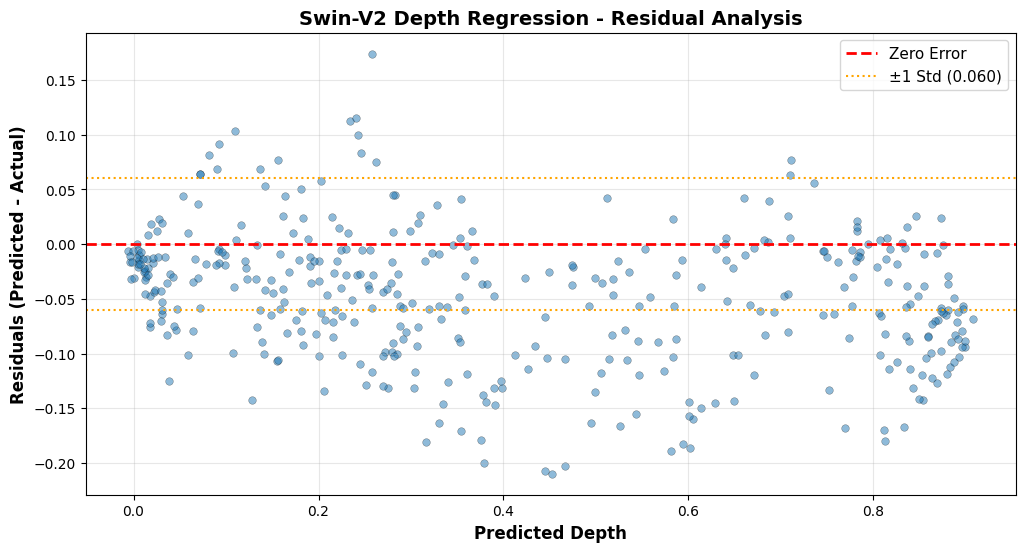

In [27]:
plot_residuals(
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    save_path=reports_dir / f'{MODEL_PREFIX}_final_residuals.png',
    title=f'{final_model_name} - Residual Analysis'
)

### 8.4 Error Distribution

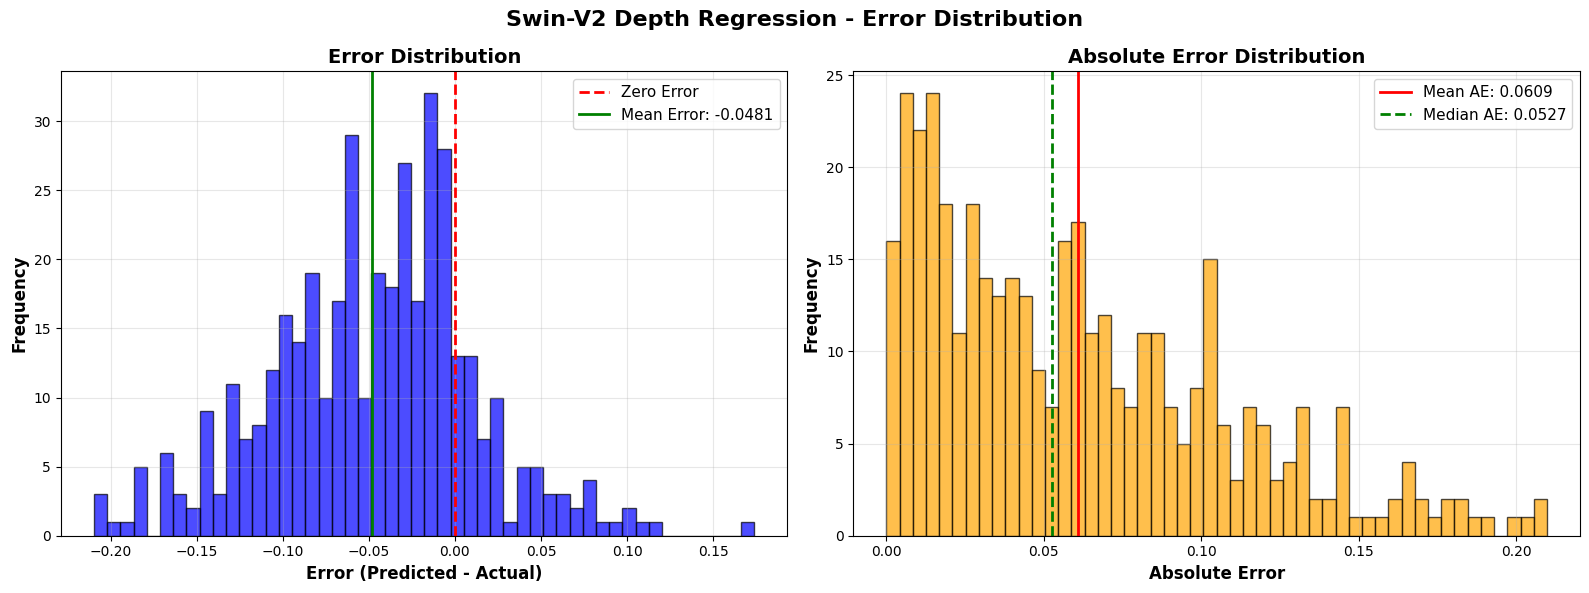

In [28]:
plot_error_distribution(
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    save_path=reports_dir / f'{MODEL_PREFIX}_final_error_distribution.png',
    title=f'{final_model_name} - Error Distribution'
)

## 8. Advanced Visualizations

Comprehensive visual analysis of the selected model.

### 8.1 Depth Predictions Gallery

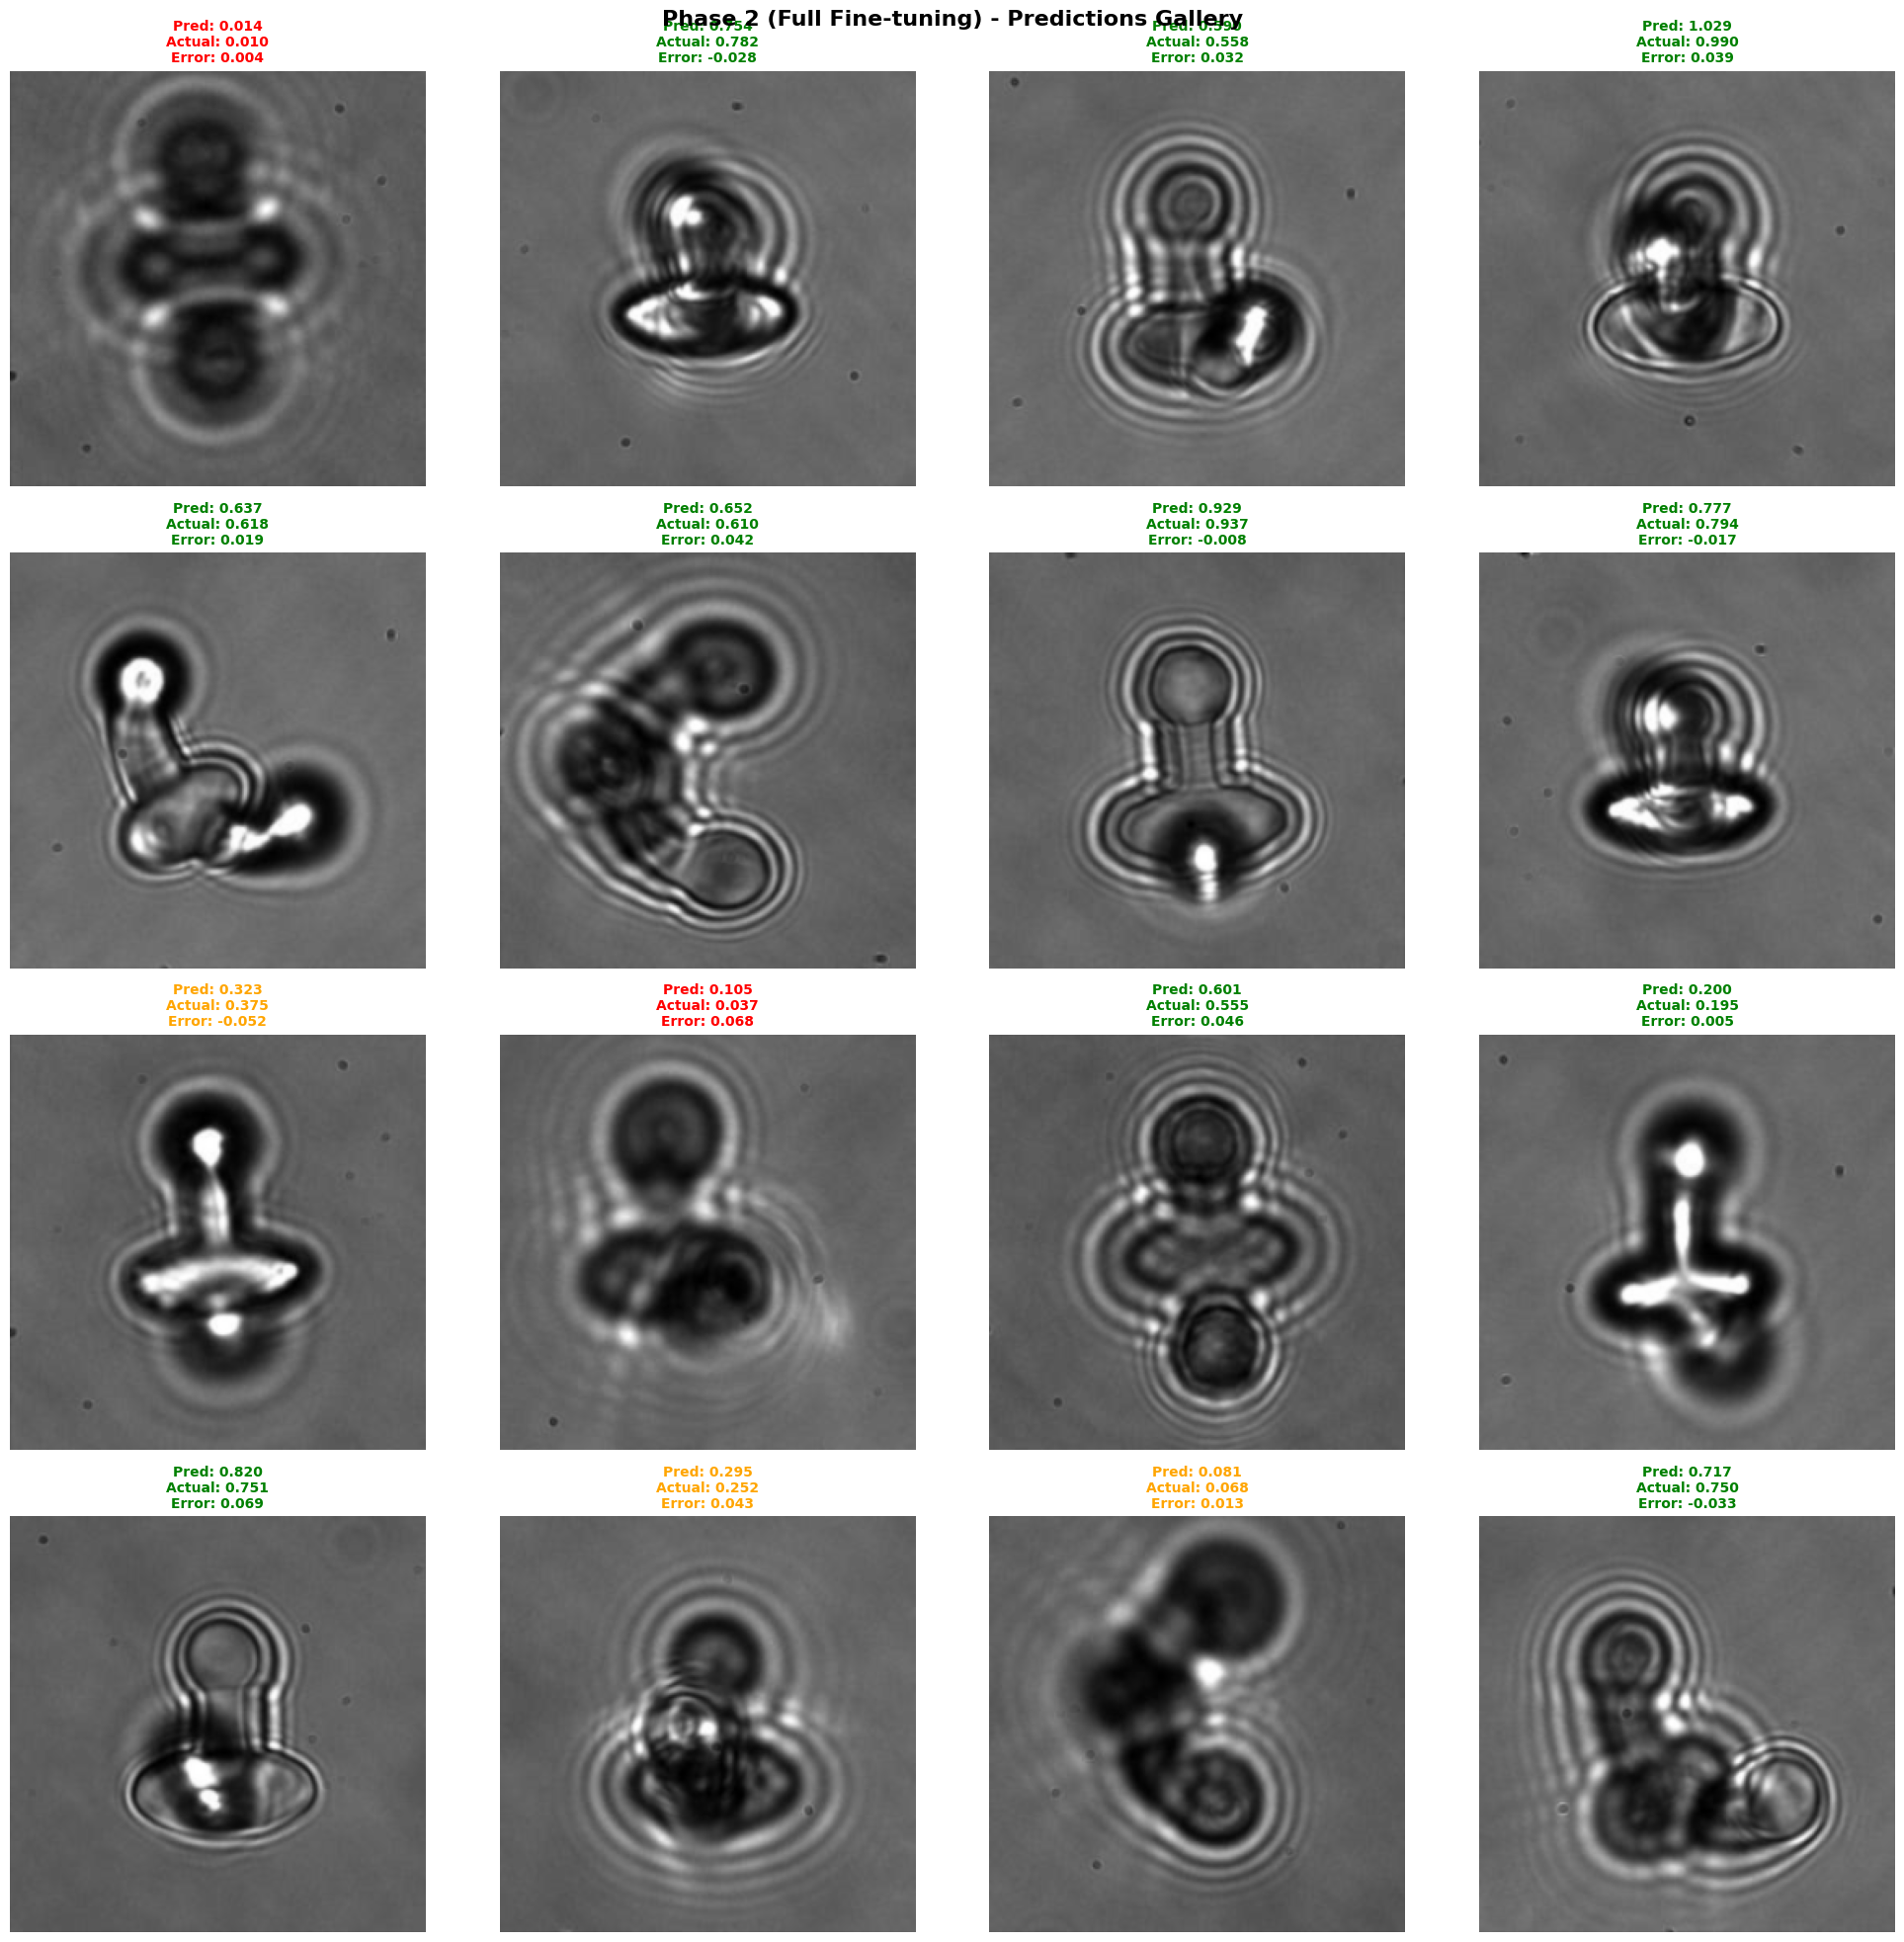

In [72]:
# Random sample of predictions
plot_depth_predictions_gallery(
    images=test_results['images'],
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    num_samples=16,
    save_path=project_root / 'reports' / f'{MODEL_PREFIX}_final_predictions_gallery.png',
    title=f'{final_model_name} - Predictions Gallery'
)

### 8.2 Best and Worst Predictions

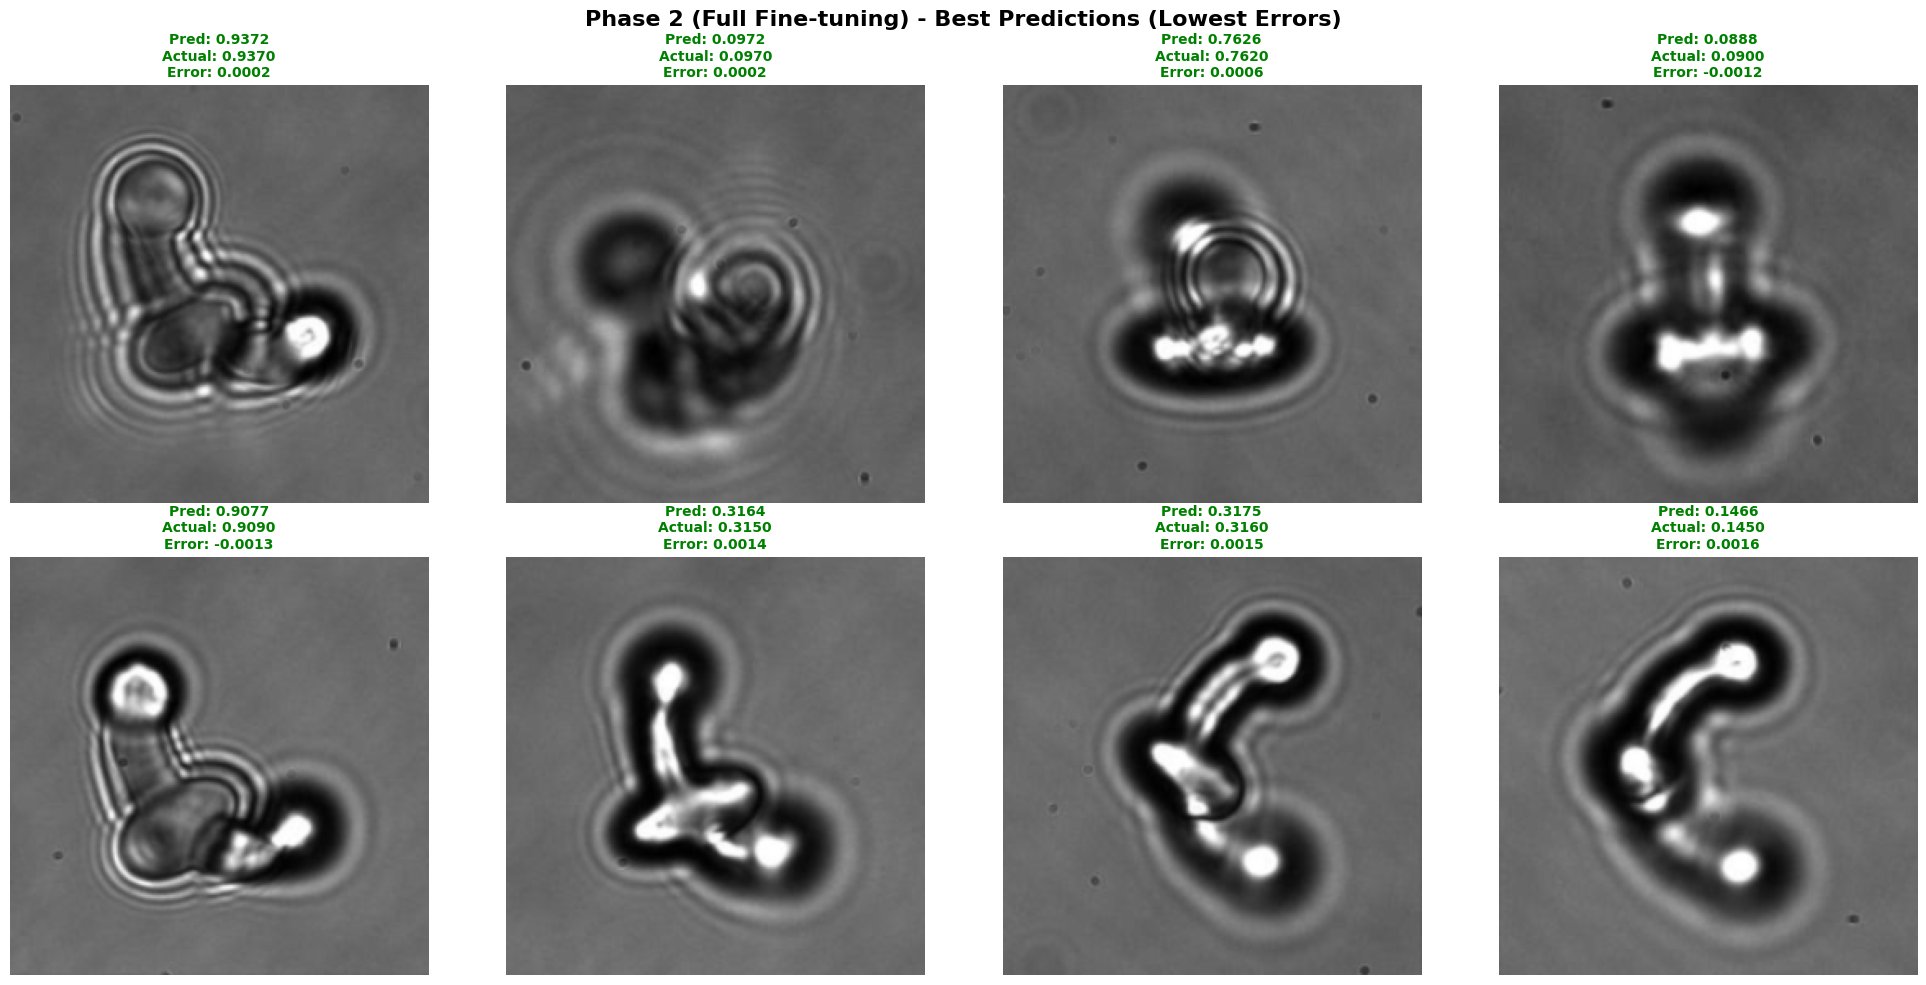

In [75]:
# Find best and worst predictions
errors = np.abs(test_results['predictions'] - test_results['targets'])
best_indices = np.argsort(errors)[:8]
worst_indices = np.argsort(errors)[-8:]

# Visualize best predictions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, idx in enumerate(best_indices):
    img = test_results['images'][idx]
    pred = test_results['predictions'][idx]
    target = test_results['targets'][idx]
    error = pred - target
    
    # Denormalize image
    img_display = img.transpose(1, 2, 0)
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    axes[i].imshow(img_display)
    axes[i].axis('off')
    axes[i].set_title(
        f'Pred: {pred:.4f}\nActual: {target:.4f}\nError: {error:.4f}',
        fontsize=10,
        fontweight='bold',
        color='green'
    )

plt.suptitle(f'{final_model_name} - Best Predictions (Lowest Errors)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'reports' / f'{MODEL_PREFIX}_best_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

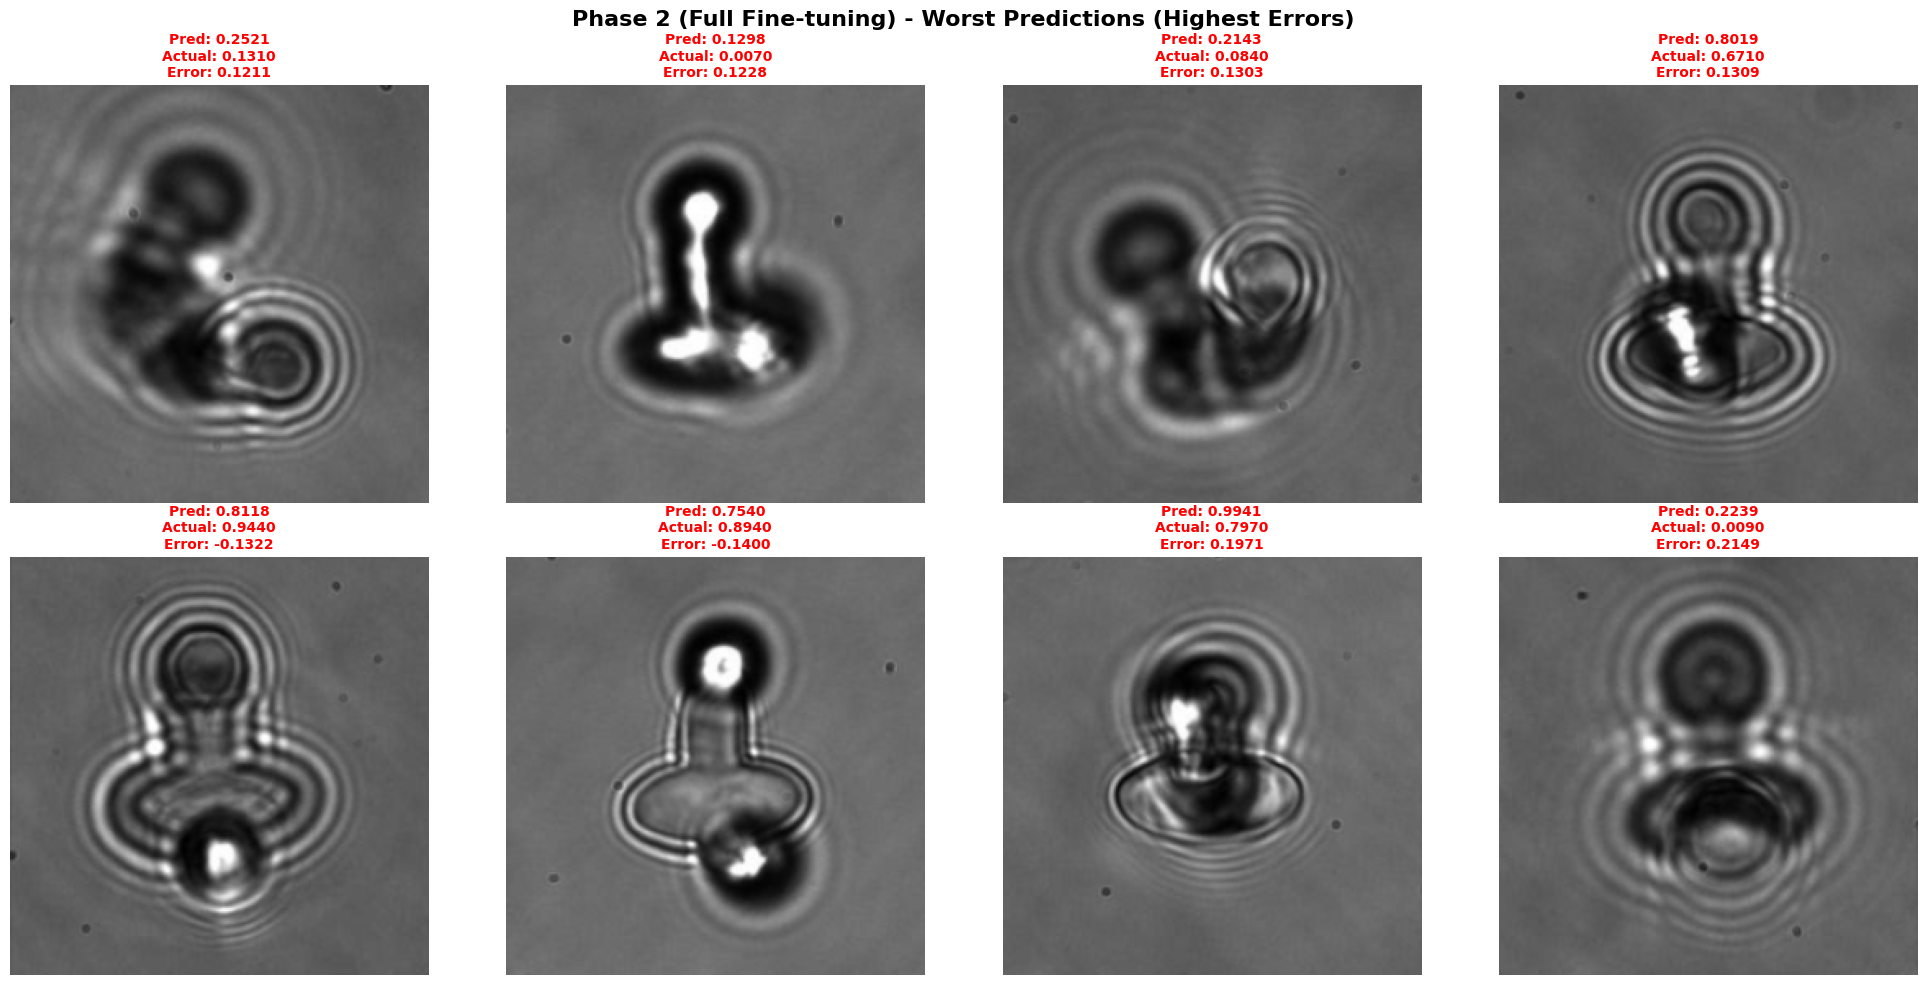

In [76]:
# Visualize worst predictions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, idx in enumerate(worst_indices):
    img = test_results['images'][idx]
    pred = test_results['predictions'][idx]
    target = test_results['targets'][idx]
    error = pred - target
    
    # Denormalize image
    img_display = img.transpose(1, 2, 0)
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    axes[i].imshow(img_display)
    axes[i].axis('off')
    axes[i].set_title(
        f'Pred: {pred:.4f}\nActual: {target:.4f}\nError: {error:.4f}',
        fontsize=10,
        fontweight='bold',
        color='red'
    )

plt.suptitle(f'{final_model_name} - Worst Predictions (Highest Errors)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'reports' / f'{MODEL_PREFIX}_worst_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.3 Error Analysis by Depth Range

NameError: name 'reports_dir' is not defined

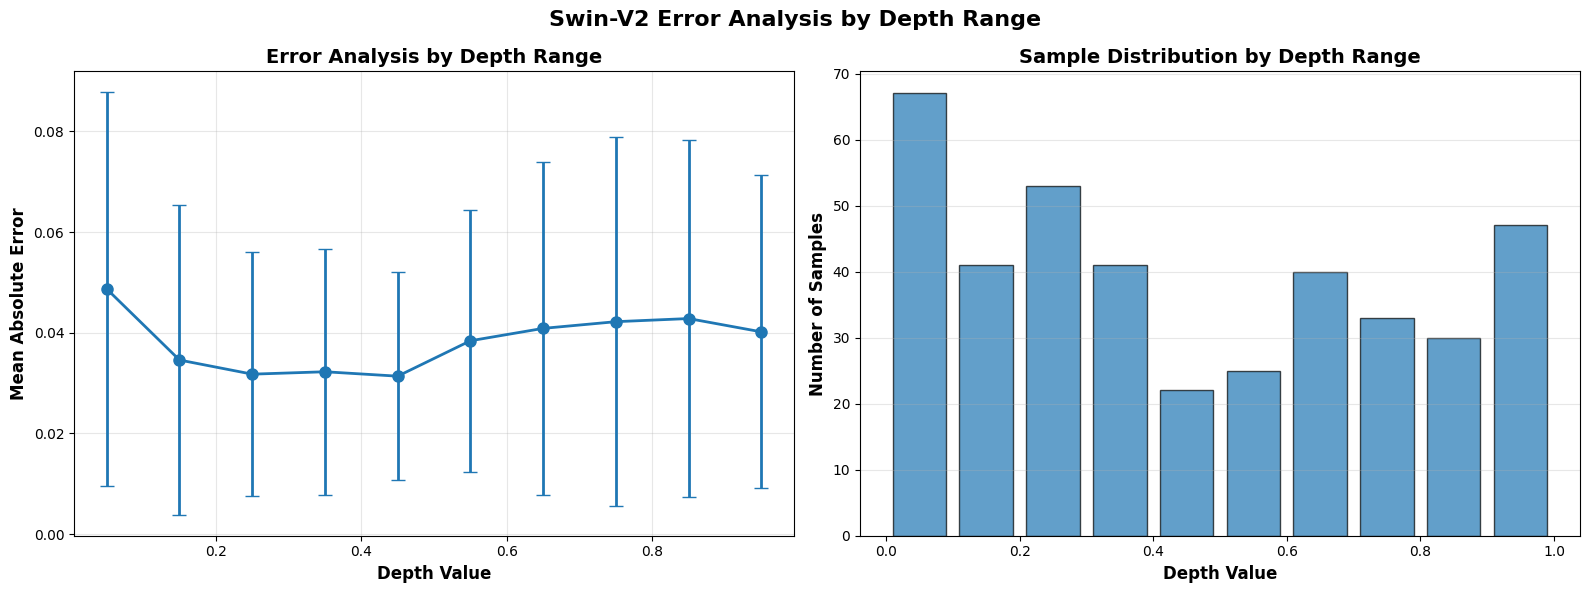

In [77]:
# Analyze errors by depth range
targets = test_results['targets']
predictions = test_results['predictions']
abs_errors = np.abs(predictions - targets)

# Create depth bins
num_bins = 10
depth_bins = np.linspace(targets.min(), targets.max(), num_bins + 1)
bin_indices = np.digitize(targets, depth_bins) - 1

# Calculate statistics per bin
bin_centers = []
bin_mean_errors = []
bin_std_errors = []
bin_counts = []

for i in range(num_bins):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        bin_centers.append((depth_bins[i] + depth_bins[i+1]) / 2)
        bin_mean_errors.append(np.mean(abs_errors[mask]))
        bin_std_errors.append(np.std(abs_errors[mask]))
        bin_counts.append(np.sum(mask))

# Plot error analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Error vs depth range
axes[0].errorbar(bin_centers, bin_mean_errors, yerr=bin_std_errors,
                 marker='o', markersize=8, capsize=5, linewidth=2)
axes[0].set_xlabel('Depth Value', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].set_title('Error Analysis by Depth Range', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Sample distribution by depth range
axes[1].bar(bin_centers, bin_counts, width=(depth_bins[1]-depth_bins[0])*0.8,
            alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Depth Value', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontweight='bold', fontsize=12)
axes[1].set_title('Sample Distribution by Depth Range', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.suptitle('Swin-V2 Error Analysis by Depth Range', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '9_swin_v2_depth_error_by_range.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.4 Transformer Attention Visualization

**Transformer-specific:** Visualize attention patterns from different Swin Transformer stages. This shows how the model focuses on different regions at different scales.

In [78]:
# Extract intermediate features from Swin Transformer stages
sample_idx = 0
sample_img = test_results['images'][sample_idx:sample_idx+1]
sample_img_tensor = torch.from_numpy(sample_img).to(device)

# Get prediction info
sample_pred = test_results['predictions'][sample_idx]
sample_target = test_results['targets'][sample_idx]

print(f"Sample #{sample_idx}:")
print(f"  Predicted: {sample_pred:.4f}")
print(f"  Actual: {sample_target:.4f}")
print(f"  Error: {sample_pred - sample_target:.4f}")

# Extract stage activations
activations = []

def get_activation(name):
    def hook(module, input, output):
        activations.append(output.detach())
    return hook

# Register hooks for Swin-V2 stages (4 stages)
hooks = []
for i in range(4):
    try:
        hook = final_model.backbone.layers[i].register_forward_hook(get_activation(f'stage{i}'))
        hooks.append(hook)
    except:
        pass

# Forward pass
with torch.no_grad():
    _ = final_model(sample_img_tensor)

# Remove hooks
for hook in hooks:
    hook.remove()

print(f"\nExtracted {len(activations)} stage activations")

Sample #0:
  Predicted: 0.2538
  Actual: 0.2180
  Error: 0.0358

Extracted 4 stage activations


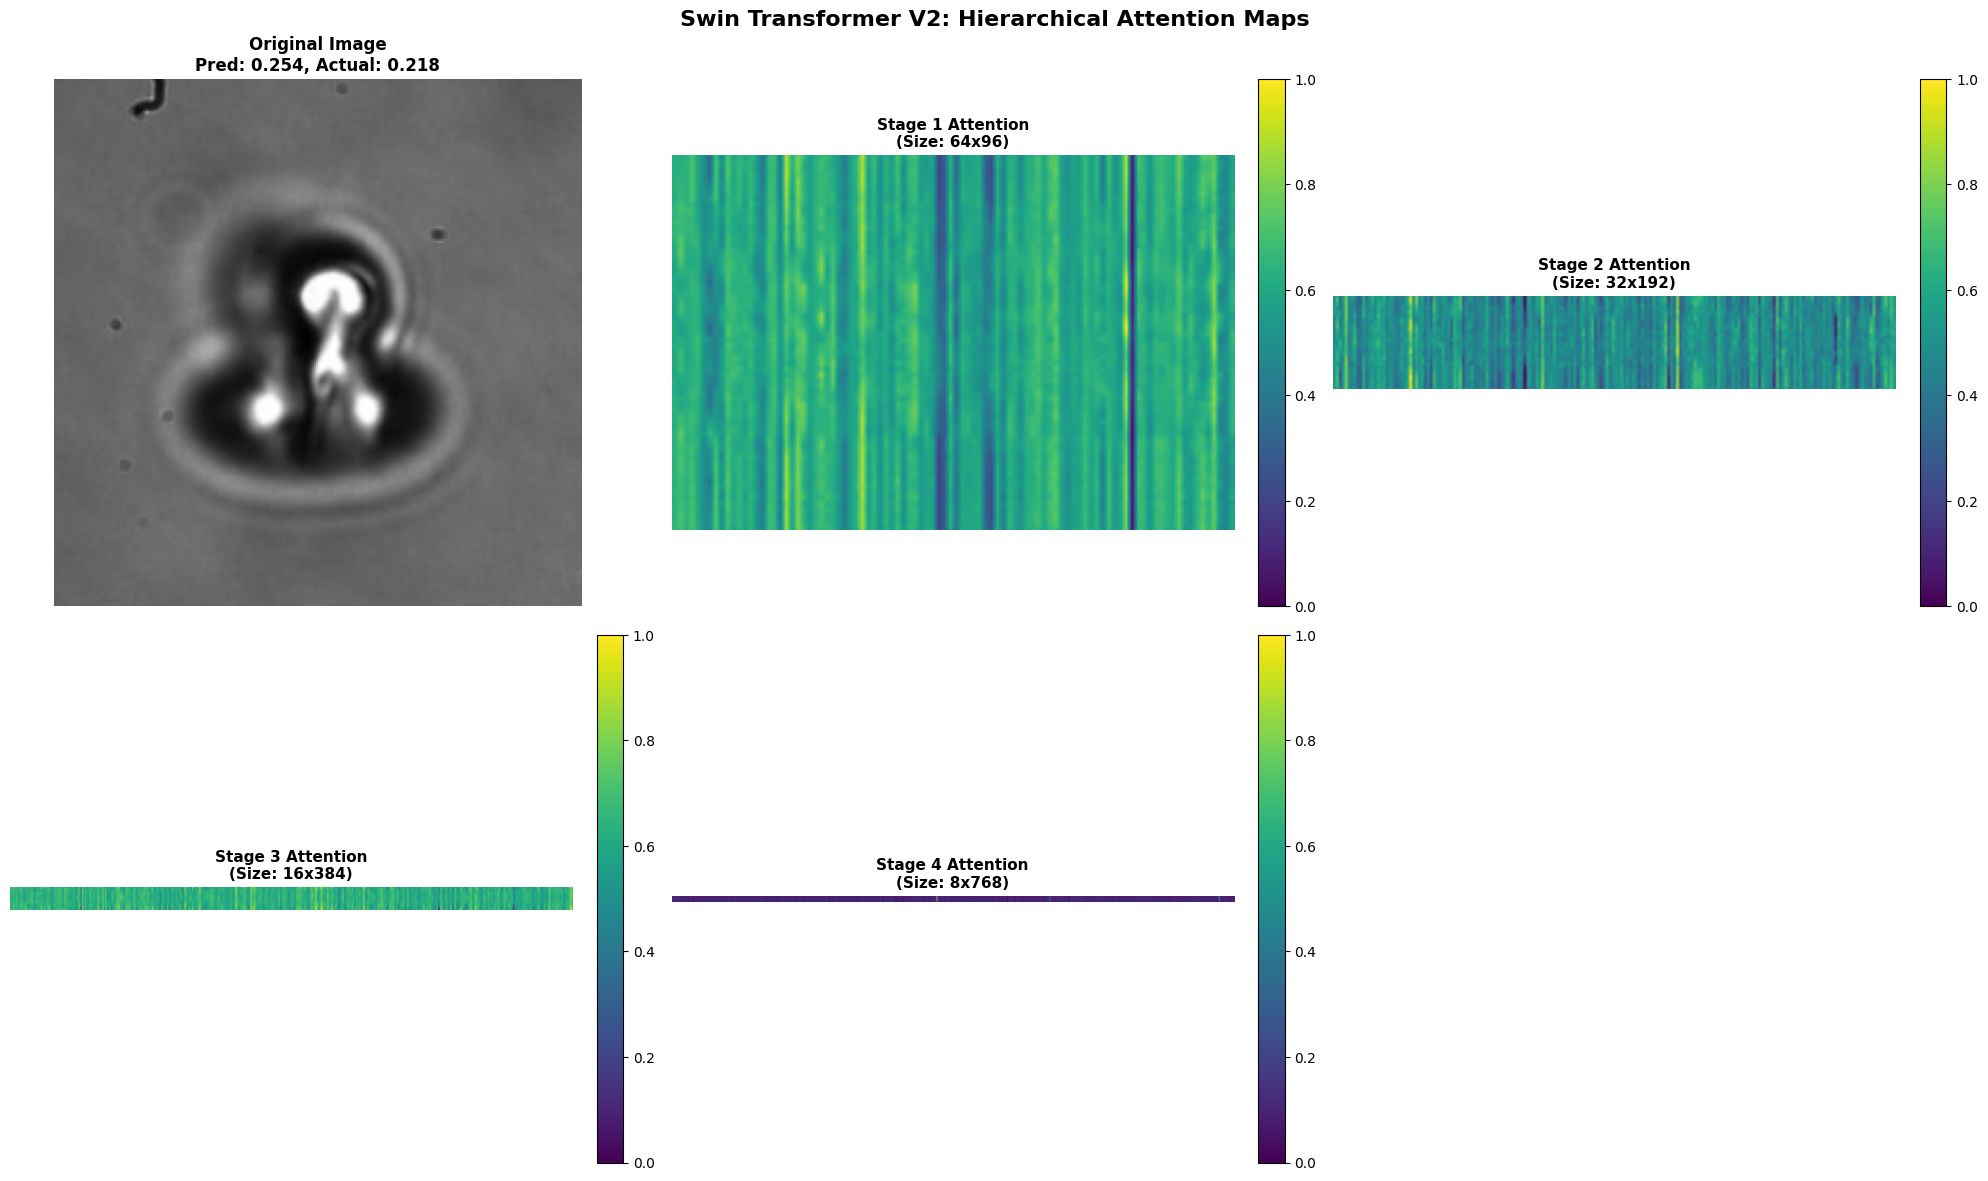


Attention maps visualization created for 4 stages


In [79]:
# Visualize attention maps from each stage
if len(activations) > 0:
    fig = plt.figure(figsize=(20, 12))
    num_stages = min(4, len(activations))
    
    # Original image
    ax = plt.subplot(2, 3, 1)
    img_display = sample_img[0].transpose(1, 2, 0)
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    ax.imshow(img_display)
    ax.set_title(f'Original Image\nPred: {sample_pred:.3f}, Actual: {sample_target:.3f}', 
                 fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # Visualize each stage
    for i, act in enumerate(activations[:5]):
        # Swin outputs are [B, H*W, C] or [B, C, H, W]
        if len(act.shape) == 3:
            # [B, H*W, C] - need to reshape and average
            act_map = act[0].mean(dim=-1)  # Average across channels
            # Reshape to 2D (approximate square)
            size = int(np.sqrt(act_map.shape[0]))
            if size * size == act_map.shape[0]:
                act_map = act_map.reshape(size, size)
            else:
                # Handle non-square
                act_map = act_map[:size*size].reshape(size, size)
        else:
            # [B, C, H, W] - average across channels
            act_map = act[0].mean(dim=0)
        
        # Normalize
        act_map = act_map.cpu().numpy()
        act_map = (act_map - act_map.min()) / (act_map.max() - act_map.min() + 1e-8)
        
        # Display
        ax = plt.subplot(2, 3, i+2)
        im = ax.imshow(act_map, cmap='viridis', interpolation='bilinear')
        ax.set_title(f'Stage {i+1} Attention\n(Size: {act_map.shape[0]}x{act_map.shape[1]})', 
                     fontsize=11, fontweight='bold')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.suptitle('Swin Transformer V2: Hierarchical Attention Maps', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'reports' / '9_swin_v2_depth_attention_maps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nAttention maps visualization created for {len(activations)} stages")
else:
    print("Could not extract stage activations")

### 8.5 Depth-Stratified Attention Analysis

**Transformer-specific:** Compare attention patterns for shallow vs deep samples to understand how the transformer adapts its focus based on depth.

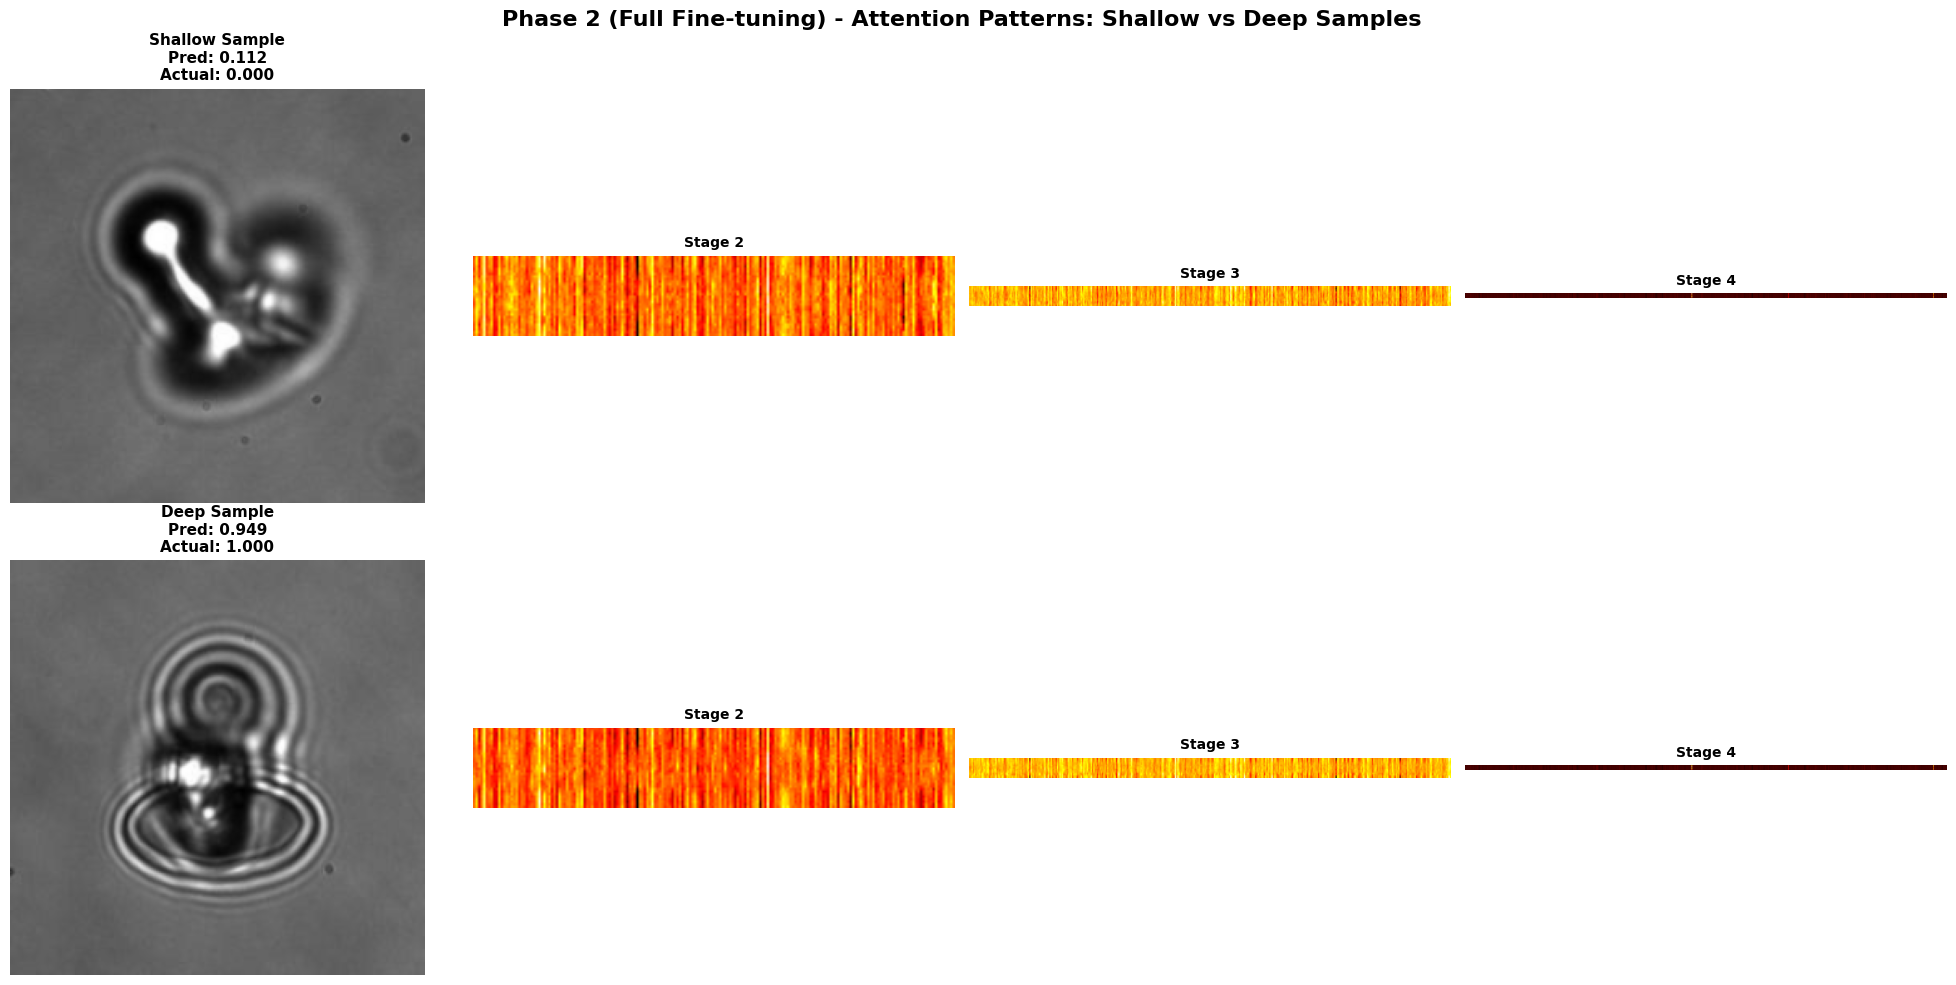


Depth-stratified attention analysis completed


In [83]:
# Select shallow and deep samples
shallow_idx = np.argmin(test_results['targets'])
deep_idx = np.argmax(test_results['targets'])

samples_to_visualize = [
    (shallow_idx, 'Shallow'),
    (deep_idx, 'Deep')
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for row_idx, (sample_idx, label) in enumerate(samples_to_visualize):
    # Get sample
    img = test_results['images'][sample_idx:sample_idx+1]
    img_tensor = torch.from_numpy(img).to(device)
    pred = test_results['predictions'][sample_idx]
    target = test_results['targets'][sample_idx]
    
    # Extract activations
    activations = []
    hooks = []
    
    for i in range(4):
        try:
            hook = final_model.backbone.layers[i].register_forward_hook(get_activation(f'stage{i}'))
            hooks.append(hook)
        except:
            pass
    
    with torch.no_grad():
        _ = final_model(img_tensor)
    
    for hook in hooks:
        hook.remove()
    
    # Show original image
    img_display = img[0].transpose(1, 2, 0)
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    axes[row_idx, 0].imshow(img_display)
    axes[row_idx, 0].set_title(
        f'{label} Sample\nPred: {pred:.3f}\nActual: {target:.3f}',
        fontsize=11, fontweight='bold'
    )
    axes[row_idx, 0].axis('off')
    
    # Show attention from last 3 stages
    for i, act_idx in enumerate([1, 2, 3]):
        if act_idx < len(activations):
            act = activations[act_idx]
            
            if len(act.shape) == 3:
                act_map = act[0].mean(dim=-1)
                size = int(np.sqrt(act_map.shape[0]))
                if size * size == act_map.shape[0]:
                    act_map = act_map.reshape(size, size)
                else:
                    act_map = act_map[:size*size].reshape(size, size)
            else:
                act_map = act[0].mean(dim=0)
            
            act_map = act_map.cpu().numpy()
            act_map = (act_map - act_map.min()) / (act_map.max() - act_map.min() + 1e-8)
            
            axes[row_idx, i+1].imshow(act_map, cmap='hot', interpolation='bilinear')
            axes[row_idx, i+1].set_title(f'Stage {act_idx+1}', fontsize=10, fontweight='bold')
            axes[row_idx, i+1].axis('off')

plt.suptitle(f'{final_model_name} - Attention Patterns: Shallow vs Deep Samples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'reports' / '9_swin_v2_depth_attention_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDepth-stratified attention analysis completed")

### 8.7 Transfer Learning Feature Analysis

In [81]:
# Analyze what features from classification help with depth estimation
# Extract features from multiple samples
final_model.eval()
features_list = []
depth_list = []

with torch.no_grad():
    for i in range(min(100, len(test_results['images']))):
        img = test_results['images'][i:i+1]
        img_tensor = torch.from_numpy(img).to(device)
        _, features = final_model(img_tensor, return_features=True)
        features_list.append(features.cpu().numpy())
        depth_list.append(test_results['targets'][i])

features_array = np.concatenate(features_list, axis=0)
depth_array = np.array(depth_list)

print(f"Extracted features shape: {features_array.shape}")
print(f"Depth values shape: {depth_array.shape}")

Extracted features shape: (100, 768)
Depth values shape: (100,)


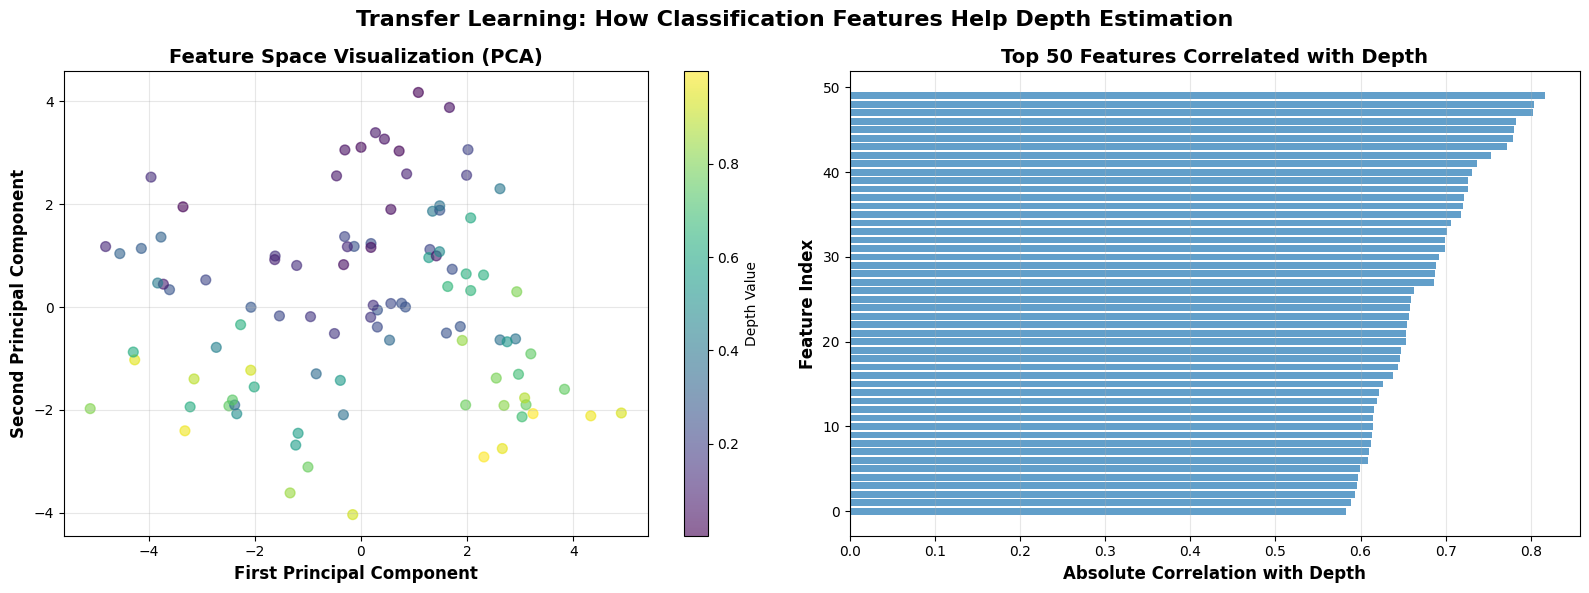


Feature Analysis:
   Total features: 768
   Mean abs correlation: 0.2818
   Max abs correlation: 0.8169
   Features with |corr| > 0.3: 321


In [82]:
# Visualize feature-depth correlation
from sklearn.decomposition import PCA

# Apply PCA to reduce feature dimensionality
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_array)

# Plot features colored by depth
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA visualization colored by depth
scatter = axes[0].scatter(features_2d[:, 0], features_2d[:, 1], 
                          c=depth_array, cmap='viridis', s=50, alpha=0.6)
axes[0].set_xlabel('First Principal Component', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Second Principal Component', fontweight='bold', fontsize=12)
axes[0].set_title('Feature Space Visualization (PCA)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='Depth Value')
axes[0].grid(alpha=0.3)

# Feature correlation with depth
feature_correlations = []
for i in range(features_array.shape[1]):
    corr = np.corrcoef(features_array[:, i], depth_array)[0, 1]
    feature_correlations.append(abs(corr))

# Plot top correlations
top_k = 50
top_indices = np.argsort(feature_correlations)[-top_k:]
axes[1].barh(range(top_k), [feature_correlations[i] for i in top_indices], alpha=0.7)
axes[1].set_xlabel('Absolute Correlation with Depth', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Feature Index', fontweight='bold', fontsize=12)
axes[1].set_title(f'Top {top_k} Features Correlated with Depth', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.suptitle('Transfer Learning: How Classification Features Help Depth Estimation', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'reports' / '9_swin_v2_depth_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFeature Analysis:")
print(f"   Total features: {features_array.shape[1]}")
print(f"   Mean abs correlation: {np.mean(feature_correlations):.4f}")
print(f"   Max abs correlation: {np.max(feature_correlations):.4f}")
print(f"   Features with |corr| > 0.3: {sum(c > 0.3 for c in feature_correlations)}")